In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

-rw-r--r-- 1 root root 64 May  4 18:38 kaggle.json
/content


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
!kaggle datasets download -d "mateuszbuda/lgg-mri-segmentation" -p "/content"

In [ ]:
import os
os.mkdir("data")

In [ ]:
!unzip /content/lgg-mri-segmentation.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /content/data/lgg-mri-segmenta

In [ ]:
#######################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import keras
import sklearn
import joblib, cv2

In [ ]:
df = pd.read_csv("/content/data_mask.csv")

In [ ]:
df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [ ]:
# Data Analysis
df["mask"].value_counts()

,count
mask,
0,2556
1,1373


In [ ]:
## data preprocessing
path = "/content/data/kaggle_3m"

imageList = []
maskList = []

for i in df.index:
  imagepath = os.path.join(path,df.loc[i,"image_path"])
  maskpath = os.path.join(path,df.loc[i,"mask_path"])
  image = cv2.imread(imagepath)
  mask = cv2.imread(maskpath)
  image = cv2.resize(image,(256,256))
  mask = cv2.resize(mask,(256,256))
  image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
  # image = cv2.equalizeHist(image)
  # mask = cv2.equalizeHist(mask)
  image = image / 255.0
  mask = mask / 255.0
  image = image.reshape(256,256,1)
  mask = mask.reshape(256,256,1)
  imageList.append(image.astype(np.float16))
  maskList.append(mask.astype(np.float16))

imageList = np.array(imageList)
maskList = np.array(maskList)

In [ ]:
print(imageList.shape)
print(maskList.shape)

print(np.unique(maskList[1801]))

(3929, 256, 256, 1)
(3929, 256, 256, 1)
[0. 1.]


In [ ]:
def plot(index):
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(imageList[index],cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(maskList[index],cmap='gray')
  plt.show()

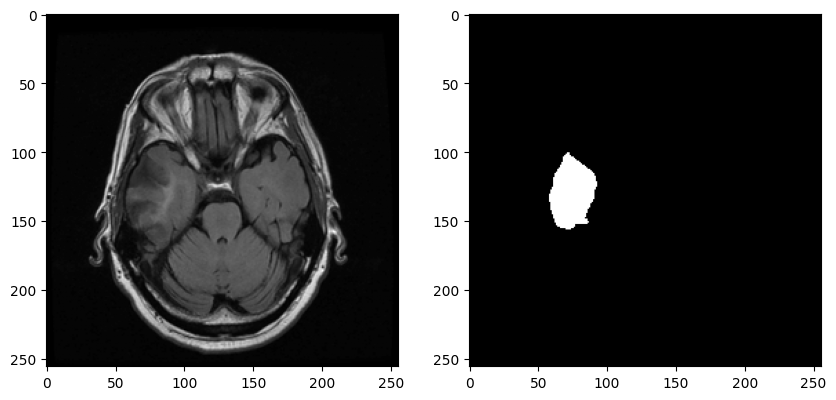

In [ ]:
plot(1801)

# Modeling

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
# ------------------------------
# 1. ResUNet Model Definition
# ------------------------------
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(num_filters, 1, padding="same")(inputs)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resunet(input_shape):
    inputs = layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(d4)

    return models.Model(inputs, outputs)

# ------------------------------
# 2. Data Preprocessing
# ------------------------------



# ------------------------------
# 4. Train/Val Split
# ------------------------------
X_train, X_val, Y_train, Y_val = train_test_split(imageList, maskList, test_size=0.2, random_state=42)


# ------------------------------
# 5. Build and Compile Model
# ------------------------------
model = build_resunet((256, 256, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------------------
# 6. Train Model
# ------------------------------
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=4
)

# ------------------------------
# 7. Visualize Prediction
# ------------------------------
def plot_sample(img, mask, pred_mask):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].set_title("Image")
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask.squeeze(), cmap='gray')
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]  

 Total params: 32,461,569 (123.83 MB)

 Trainable params: 32,443,905 (123.76 MB)

 Non-trainable params: 17,664 (69.00 KB)

Epoch 1/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 370s 391ms/step - accuracy: 0.9798 - loss: 0.0716 - val_accuracy: 0.9898 - val_loss: 0.0367
Epoch 2/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 272s 308ms/step - accuracy: 0.9906 - loss: 0.0325 - val_accuracy: 0.9865 - val_loss: 0.0370
Epoch 3/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 265s 312ms/step - accuracy: 0.9914 - loss: 0.0277 - val_accuracy: 0.9918 - val_loss: 0.0260
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 262s 312ms/step - accuracy: 0.9927 - loss: 0.0220 - val_accuracy: 0.9930 - val_loss: 0.0221
Epoch 5/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 262s 312ms/step - accuracy: 0.9935 - loss: 0.0190 - val_accuracy: 0.9929 - val_loss: 0.0207
Epoch 6/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 262s 312ms/step - accuracy: 0.9945 - loss: 0.0153 - val_accuracy: 0.9927 - val_loss: 0.0188
Epoch 7/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 259s 308ms/step - accuracy: 0.9952 - loss: 0.0132 - val_accuracy: 0.9945 - val_loss: 0.0147
Epoch 8/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 265s 312ms/step - accuracy: 0.9959 -

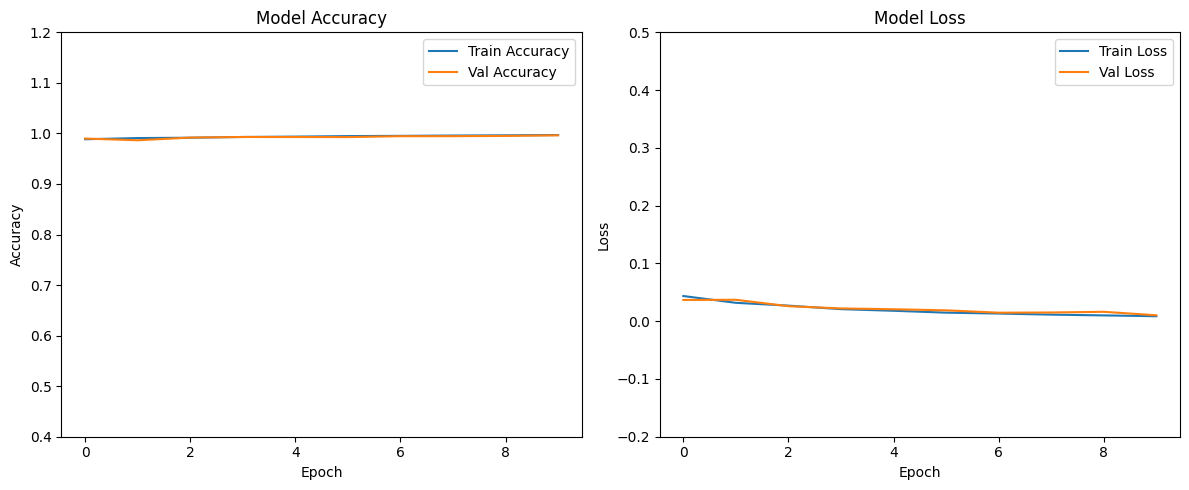

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from a Keras History object.

    Parameters:
    - history: The History object returned by model.fit()
    """
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.2)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(-0.2, 0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


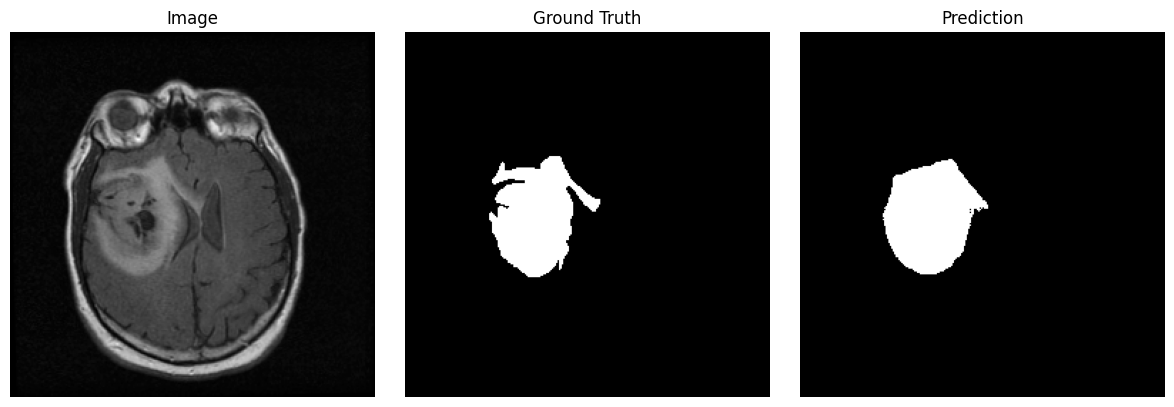

In [ ]:
i = np.random.randint(0, len(X_val))
sample_img = X_val[i]
sample_mask = Y_val[i]
pred = model.predict(np.expand_dims(sample_img, axis=0))[0]
pred_mask = (pred > 0.5).astype(np.uint8)

plot_sample(sample_img, sample_mask, pred_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


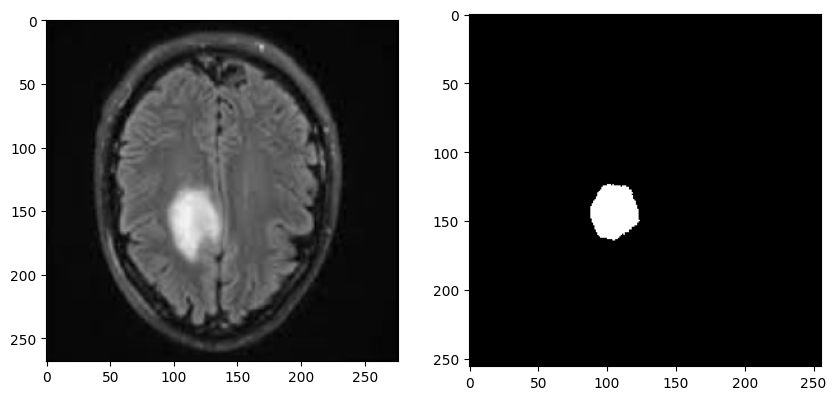

In [ ]:
def predict_mask(image):
   image = cv2.resize(image, (256, 256))
   image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   image = image.reshape(-1, 256, 256, 1)
   image = image / 255.0
   pred = model.predict(image)[0]
   pred_mask = (pred > 0.5).astype(np.uint8)
   return pred_mask
image = cv2.imread("/content/Screenshot 2025-05-05 011444.png")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(predict_mask(image),cmap='gray')
plt.show()
#

In [ ]:
model.save("ResUnet.keras")